# Training on 25,000 events. Testing on the RAMP set.

In [1]:
!nvidia-smi

Wed Aug 30 13:46:14 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   33C    P2    37W / 180W |    617MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   31C    P8     9W / 180W |   5655MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


### Load in the data.

In [5]:
%%time
modelpath   = "data/models/NORM-10N-25T-25000E-235R.h5"
trainpath   = "data/sets/NORM-10N-25T-25000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-3600E-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)
train       = utils.list_of_groups(train_frame, group="event_id")
test        = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")
else:
    del train_frame
    del test_frame # To save on memory space.

Train is list of 25000 events.
Test is list of 3600 events.
CPU times: user 10.4 s, sys: 288 ms, total: 10.7 s
Wall time: 10.7 s


In [3]:
order = ["phi", "r", "z"]

### Show an example of the data.

In [ ]:
n = 8881 #np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [ ]:
print(n)
visuals.display(train[n], order)

### Create the model.

In [6]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [7]:
# If you have already created a model, run this cell to load the model.
# Else, just run the cell below this cell.
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [9]:
%%time
# Current model has been trained on 68 epochs before early stopping.
epochs     = 128
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
        keras.callbacks.EarlyStopping(patience=5, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)]))

Epoch 1/128
250/250 [==============================] - 371s - loss: 0.6141 - acc: 0.7739 - val_loss: 0.2840 - val_acc: 0.9046
Epoch 2/128
250/250 [==============================] - 355s - loss: 0.5941 - acc: 0.7833 - val_loss: 0.2721 - val_acc: 0.9106
Epoch 3/128
250/250 [==============================] - 354s - loss: 0.5733 - acc: 0.7943 - val_loss: 0.2689 - val_acc: 0.9124
Epoch 4/128
250/250 [==============================] - 354s - loss: 0.5534 - acc: 0.8041 - val_loss: 0.2619 - val_acc: 0.9157
Epoch 5/128
250/250 [==============================] - 354s - loss: 0.5444 - acc: 0.8083 - val_loss: 0.2558 - val_acc: 0.9186
Epoch 6/128
250/250 [==============================] - 354s - loss: 0.5318 - acc: 0.8148 - val_loss: 0.2523 - val_acc: 0.9205
Epoch 7/128
250/250 [==============================] - 355s - loss: 0.5204 - acc: 0.8202 - val_loss: 0.2566 - val_acc: 0.9178
Epoch 8/128
250/250 [==============================] - 354s - loss: 0.5116 - acc: 0.8246 - val_loss: 0.2518 - val_acc:

### Display information about the model after fitting it.

In [8]:
%%time
test.sort(key=lambda x: x.iloc[0]["event_id"])
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 84.50846411699683%
Percent of tracks assigned correctly: 58.999619144344294%
Percent of events with the correct number of tracks: 81.11111111111111%
CPU times: user 1min 38s, sys: 128 ms, total: 1min 38s
Wall time: 1min 38s


In [12]:
dist = metrics.distributions(pd.concat(train))
for i in range(len(dist[0])):
    print("There are {0} events with {1} tracks.".format(dist[1][i], dist[0][i]))

There are 43 events with 1 tracks.
There are 41 events with 2 tracks.
There are 81 events with 3 tracks.
There are 149 events with 4 tracks.
There are 256 events with 5 tracks.
There are 429 events with 6 tracks.
There are 640 events with 7 tracks.
There are 973 events with 8 tracks.
There are 1362 events with 9 tracks.
There are 1632 events with 10 tracks.
There are 2101 events with 11 tracks.
There are 2354 events with 12 tracks.
There are 2434 events with 13 tracks.
There are 2434 events with 14 tracks.
There are 2447 events with 15 tracks.
There are 2102 events with 16 tracks.
There are 1697 events with 17 tracks.
There are 1288 events with 18 tracks.
There are 954 events with 19 tracks.
There are 660 events with 20 tracks.
There are 394 events with 21 tracks.
There are 247 events with 22 tracks.
There are 139 events with 23 tracks.
There are 74 events with 24 tracks.
There are 69 events with 25 tracks.


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 92.20779220779221%
Percent of tracks assigned correctly: 66.66666666666666%


<IPython.core.display.Javascript object>


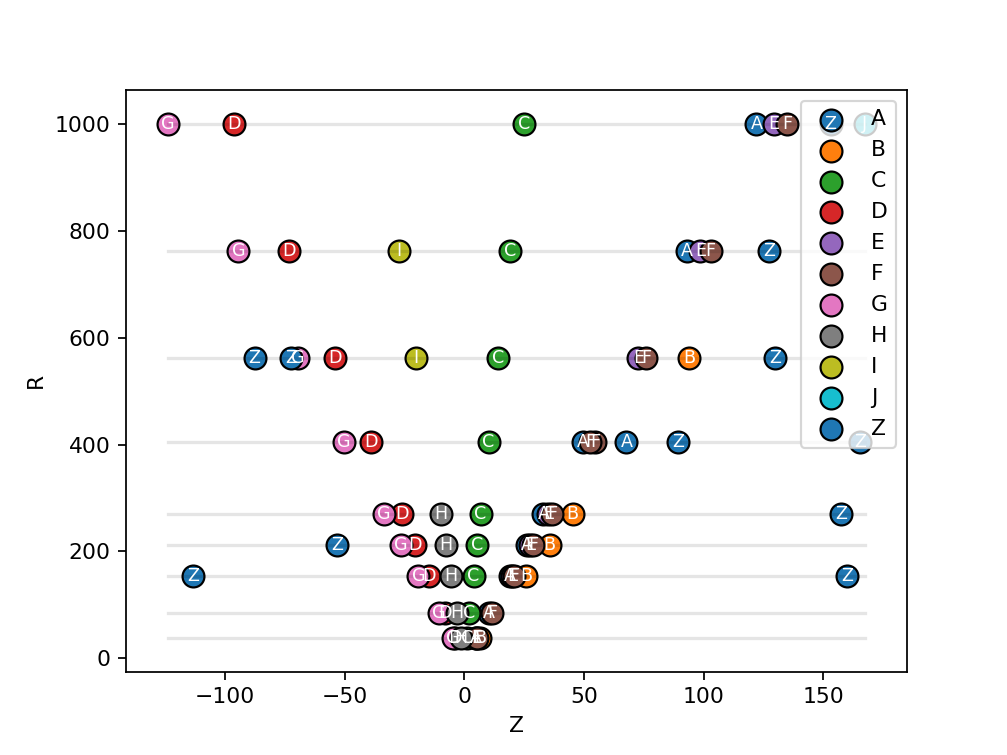

<IPython.core.display.Javascript object>


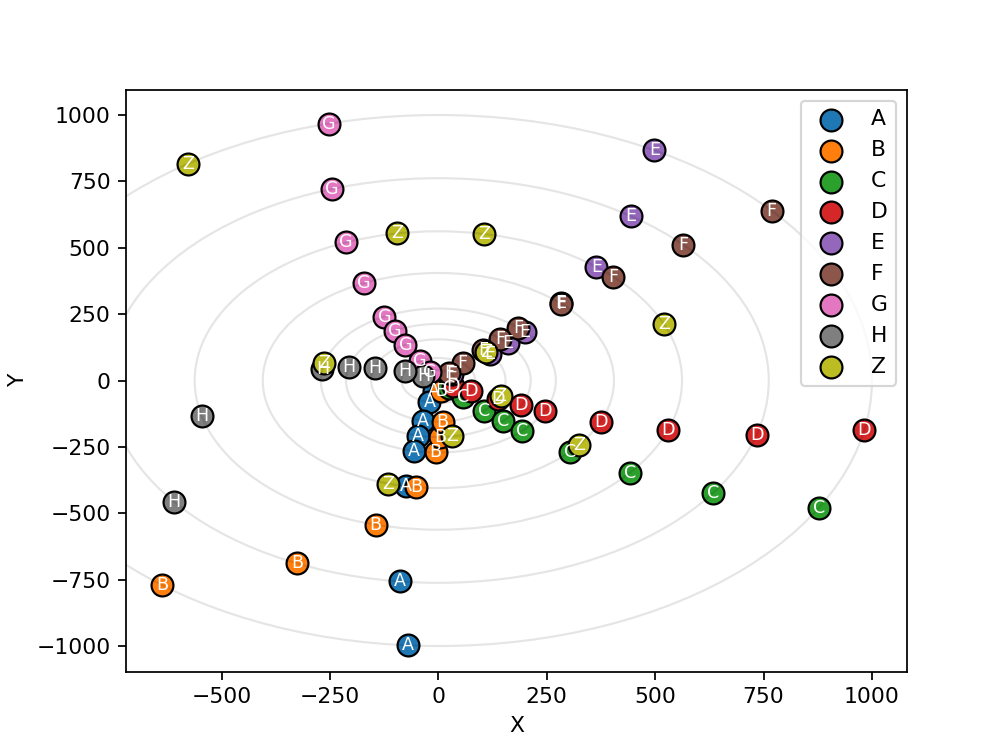

In [10]:
n = 10
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
_ = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="zr")
_ = visuals.Plot2D(test[n], order).plot(mode="xy")

In [ ]:
d = visuals.Plot3D(test[n], order, guesses[n]).plot(title="Best Guess")
d = visuals.Plot3D(test[n], order).plot(title="Answer")

In [11]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.903162,562.0,-20.271684,,,,,,,,`1`[0],`0`[1],,,,,,,,,,,,,,,,,,
1,-2.498550,762.0,-27.485807,,,,,,,,`1`[0],`0`[1],,,,,,,,,,,,,,,,,,
2,-2.262245,1000.0,167.339222,,`1`[0],,,,,,,,`0`[1],,,,,,,,,,,,,,,,,
3,-2.011937,762.0,127.512487,,`1`[0],,,,,,,,,,,,,,,,,,,,,,,,`0`[1],
4,-1.861983,405.0,89.465983,,,,,,,,,,,,,,,,,,,,,,,,,,`1`[1],
5,-1.830579,562.0,94.044643,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,
6,-1.826880,39.0,4.760687,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
7,-1.816456,85.0,10.375856,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
8,-1.802085,155.0,18.920679,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
9,-1.790836,213.0,26.000675,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,


### Display the graphs.

<IPython.core.display.Javascript object>


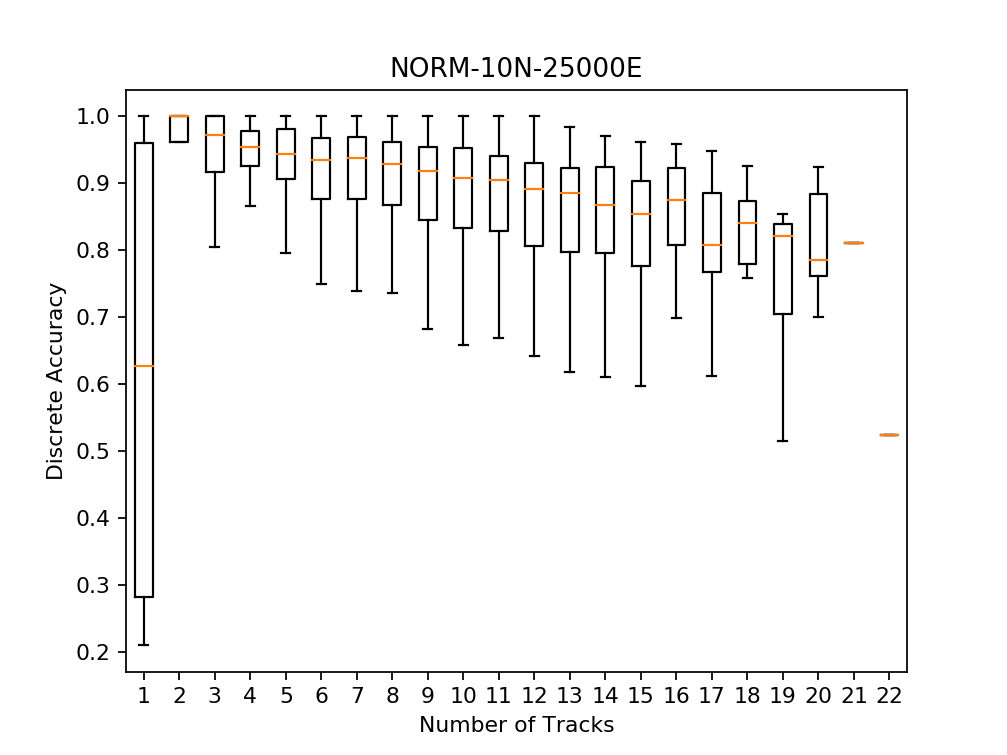

CPU times: user 29.9 s, sys: 28 ms, total: 29.9 s
Wall time: 29.9 s


In [13]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "NORM-10N-25000E", "Number of Tracks", "Discrete Accuracy", xticks=list(r))